<a href="https://colab.research.google.com/github/thanhnguyen2612/diveintocode-ml/blob/master/ML_Sprint14_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras

## [Problem 1] Sharing and executing the official tutorial model (Sentiment Analysis)

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

### Prepare data

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 3s 0us/step


In [4]:
os.listdir(dataset_dir)

['README', 'train', 'imdbEr.txt', 'test', 'imdb.vocab']

In [5]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'urls_pos.txt',
 'pos',
 'urls_unsup.txt',
 'unsupBow.feat',
 'unsup',
 'urls_neg.txt']

In [6]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [8]:
batch_size = 42
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b"Rob Estes, Josie Bisset and a crap load of kids that look nothing like either of them.<br /><br />Basically, Rob and Josie have a shotgun wedding on a drunken night during a Vegas vacation. They each come home to find that their respective children already know of the nuptials due to tabloid-like not-so-fodder. They, Rob and Josie, move both of them and their eight kids into one or the other's house.<br /><br />Rob builds furniture, I think, which is close enough to Frank Lambert's (Patrick Duffy) construction job on the much similar Step by Step to warrant eternal mockage.<br /><br />Josie is some sort of cookie-making queen, though it doesn't look like she makes any of the cookies. Not close enough to Carol Foster's (Suzanne Somers)hairdressing job to warrant likeness mockage, but hilariously preposterous enough to warrant atrocity mockage.<br /><br />Unlike Step by Step, they were a couple before the vacation and actually knew one another's last names, or so one assumes if 

In [10]:
print("Lael 0 corresponds to ", raw_train_ds.class_names[0])
print("Lael 1 corresponds to ", raw_train_ds.class_names[1])

Lael 0 corresponds to  neg
Lael 1 corresponds to  pos


In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b"Live Feed is set in some unnamed Chinese/Japanese Asian district somewhere as five American friends, Sarah (Ashley Schappert), Emily (Taayla Markell), Linda (Caroline Chojnacki), Mike (Lee Tichon) & Darren (Rob Scattergood) are enjoying a night on the town & taking in the sights. After a scuffle in a bar with a Japanese Triad boss (Stephen Chang) they decide to check out a porno theatre, as you would. Inside they are separated & quickly find out that the place belongs to the Triad boss who uses it to torture & kill people for reasons which aren't made clear. Can local boy Miles (Kevan Ohtsji) save them?<br /><br />This Canadian production was co-written, produced & directed by Ryan Nicholson who also gets a prosthetic effects designer credit as well, one has to say that Live Feed is another pretty poor low budget shot on a camcorder type horror film that seems to exist only to cash in on the notoriety & success of Hostel (2005) & the mini craze for 'torture porn' as 

In [16]:
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

1287 --->  silent
313 --->  night
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [19]:
embedding_dims = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dims),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [20]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
477/477 [==============================] - 11s 21ms/step - loss: 0.6732 - binary_accuracy: 0.6877 - val_loss: 0.6383 - val_binary_accuracy: 0.7652
Epoch 2/10
477/477 [==============================] - 3s 7ms/step - loss: 0.5830 - binary_accuracy: 0.7872 - val_loss: 0.5380 - val_binary_accuracy: 0.8110
Epoch 3/10
477/477 [==============================] - 3s 6ms/step - loss: 0.4863 - binary_accuracy: 0.8290 - val_loss: 0.4589 - val_binary_accuracy: 0.8348
Epoch 4/10
477/477 [==============================] - 3s 7ms/step - loss: 0.4169 - binary_accuracy: 0.8554 - val_loss: 0.4056 - val_binary_accuracy: 0.8540
Epoch 5/10
477/477 [==============================] - 3s 7ms/step - loss: 0.3681 - binary_accuracy: 0.8689 - val_loss: 0.3707 - val_binary_accuracy: 0.8634
Epoch 6/10
477/477 [==============================] - 3s 7ms/step - loss: 0.3344 - binary_accuracy: 0.8794 - val_loss: 0.3470 - val_binary_accuracy: 0.8674
Epoch 7/10
477/477 [==============================] - 3s 7ms/s

### Evaluate the model

In [21]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

596/596 [==============================] - 8s 12ms/step - loss: 0.3186 - binary_accuracy: 0.8706
Loss:  0.3186224102973938
Accuracy:  0.870639979839325


### Create a plot of accuracy and loss over time

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

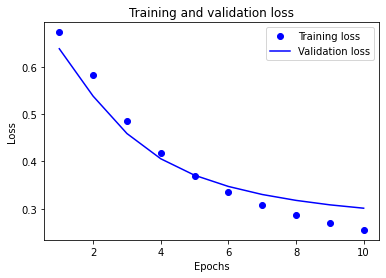

In [23]:
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

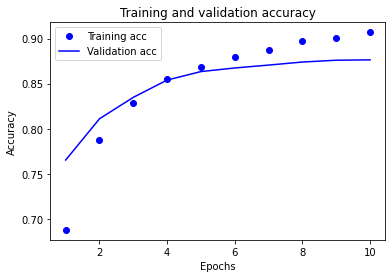

In [24]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Inference on new data (combine Vectorization Layer to Model for later exporting)

In [25]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

596/596 [==============================] - 8s 13ms/step - loss: 0.3186 - accuracy: 0.8706
0.870639979839325


In [26]:
examples = [
    "The movies was great!",
    "The movies was okay.",
    "The movies was terrible...",
]

export_model.predict(examples)

array([[0.6226305 ],
       [0.46881565],
       [0.392487  ]], dtype=float32)

## [Problem 2] (Advance assignment) Execute various methods

## [Problem 3] Learning Iris (binary classification) with Keras

In [27]:
df = pd.read_csv('Iris.csv')
data = df[df['Species'].isin(['Iris-versicolor', 'Iris-virginica'])]
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
50,51,7.0,3.2,4.7,1.4,Iris-versicolor
51,52,6.4,3.2,4.5,1.5,Iris-versicolor
52,53,6.9,3.1,4.9,1.5,Iris-versicolor
53,54,5.5,2.3,4.0,1.3,Iris-versicolor
54,55,6.5,2.8,4.6,1.5,Iris-versicolor


In [28]:
X = data.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y = data['Species']
y = np.where(y == 'Iris-versicolor', 0, 1)
X = np.array(X)
y = np.array(y)
y = y.astype(np.int32)[:, np.newaxis]
print(X.shape, y.shape)

(100, 4) (100, 1)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 4), (20, 4), (80, 1), (20, 1))

In [30]:
# Model using Sequential model
model = tf.keras.Sequential(name="iris_binary_classifier")
model.add(tf.keras.layers.Input(shape=(4,)))
model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_crossentropy', 'accuracy'])

In [31]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    validation_split=0.2,
                    verbose=2)

Epoch 1/10
7/7 - 1s - loss: 0.7142 - binary_crossentropy: 0.7142 - accuracy: 0.4844 - val_loss: 0.6758 - val_binary_crossentropy: 0.6758 - val_accuracy: 0.5625
Epoch 2/10
7/7 - 0s - loss: 0.7244 - binary_crossentropy: 0.7244 - accuracy: 0.4844 - val_loss: 0.6569 - val_binary_crossentropy: 0.6569 - val_accuracy: 0.5625
Epoch 3/10
7/7 - 0s - loss: 0.6527 - binary_crossentropy: 0.6527 - accuracy: 0.6562 - val_loss: 0.7254 - val_binary_crossentropy: 0.7254 - val_accuracy: 0.4375
Epoch 4/10
7/7 - 0s - loss: 0.6885 - binary_crossentropy: 0.6885 - accuracy: 0.5156 - val_loss: 0.6652 - val_binary_crossentropy: 0.6652 - val_accuracy: 0.6250
Epoch 5/10
7/7 - 0s - loss: 0.6487 - binary_crossentropy: 0.6487 - accuracy: 0.6250 - val_loss: 0.6182 - val_binary_crossentropy: 0.6182 - val_accuracy: 0.5625
Epoch 6/10
7/7 - 0s - loss: 0.6260 - binary_crossentropy: 0.6260 - accuracy: 0.5000 - val_loss: 0.6127 - val_binary_crossentropy: 0.6127 - val_accuracy: 1.0000
Epoch 7/10
7/7 - 0s - loss: 0.6131 - bin

In [32]:
def visualize(history_dict, metric='loss'):
    train = history_dict[metric]
    val = history_dict[f"val_{metric}"]
    epochs = range(1, len(train) + 1)

    plt.plot(epochs, train, 'bo', label='Training')
    plt.plot(epochs, val, 'b', label='Validation')
    plt.title(f"Training and validation {metric}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_crossentropy', 'accuracy', 'val_loss', 'val_binary_crossentropy', 'val_accuracy'])

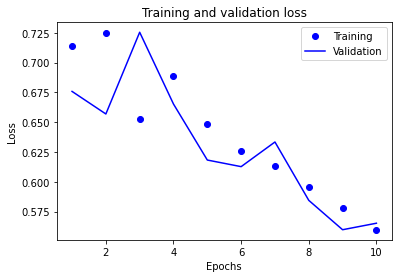

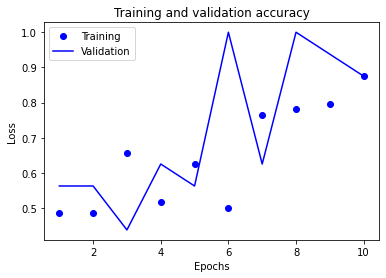

In [34]:
visualize(history_dict, metric='loss')
visualize(history_dict, metric='accuracy')

In [35]:
test_loss, test_metric_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test loss {test_loss:.4f} - Test acc: {test_acc:.4f}")

1/1 - 0s - loss: 0.5607 - binary_crossentropy: 0.5607 - accuracy: 0.9000
Test loss 0.5607 - Test acc: 0.9000


## [Problem 4] Learn Iris (multi-level classification) with Keras

In [36]:
from sklearn.preprocessing import OneHotEncoder

X, y = df.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']], df['Species']
X = np.array(X)
y = np.array(y).reshape(-1, 1)
y = OneHotEncoder(sparse=False).fit_transform(y)

X.shape, y.shape

((150, 4), (150, 3))

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

In [38]:
# Model using Functional API

input = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation='relu')(input)
x = tf.keras.layers.Dense(100, activation='relu')(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                250       
_________________________________________________________________
dense_5 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=10,
                    validation_split=0.2,
                    verbose=2)

history_dict = history.history
history_dict.keys()

Epoch 1/10
10/10 - 1s - loss: 0.8988 - accuracy: 0.5417 - auc: 0.7826 - val_loss: 0.9988 - val_accuracy: 0.5417 - val_auc: 0.6662
Epoch 2/10
10/10 - 0s - loss: 0.7501 - accuracy: 0.7292 - auc: 0.8979 - val_loss: 0.7841 - val_accuracy: 0.5417 - val_auc: 0.8832
Epoch 3/10
10/10 - 0s - loss: 0.6125 - accuracy: 0.7812 - auc: 0.9650 - val_loss: 0.6941 - val_accuracy: 0.5833 - val_auc: 0.9002
Epoch 4/10
10/10 - 0s - loss: 0.5190 - accuracy: 0.7396 - auc: 0.9619 - val_loss: 0.6127 - val_accuracy: 0.5833 - val_auc: 0.9036
Epoch 5/10
10/10 - 0s - loss: 0.4433 - accuracy: 0.8125 - auc: 0.9708 - val_loss: 0.5278 - val_accuracy: 0.8333 - val_auc: 0.9449
Epoch 6/10
10/10 - 0s - loss: 0.3892 - accuracy: 0.9167 - auc: 0.9871 - val_loss: 0.4491 - val_accuracy: 0.8333 - val_auc: 0.9783
Epoch 7/10
10/10 - 0s - loss: 0.3550 - accuracy: 0.9271 - auc: 0.9856 - val_loss: 0.4796 - val_accuracy: 0.7500 - val_auc: 0.9340
Epoch 8/10
10/10 - 0s - loss: 0.3361 - accuracy: 0.9375 - auc: 0.9877 - val_loss: 0.4085 -

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc'])

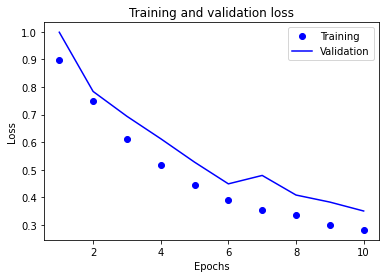

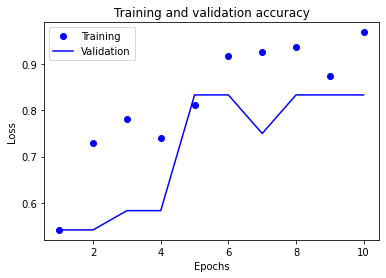

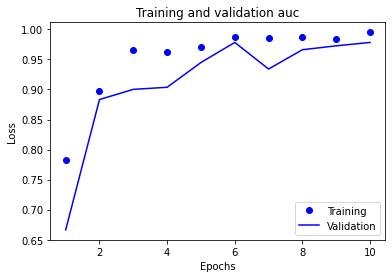

In [40]:
visualize(history_dict, 'loss')
visualize(history_dict, 'accuracy')
visualize(history_dict, 'auc')

In [41]:
model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - loss: 0.3094 - accuracy: 0.9000 - auc: 0.9881


[0.30937132239341736, 0.8999999761581421, 0.9880555868148804]

## [Problem 5] Learning House Prices with Keras

In [42]:
df = pd.read_csv('train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [43]:
X, y = df[["GrLivArea", "YearBuilt"]], df[["SalePrice"]]
X = np.array(np.log1p(X))
y = np.array(np.log1p(y))

X.shape, y.shape

((1460, 2), (1460, 1))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 2), (292, 2), (1168, 1), (292, 1))

In [45]:
# Model by class + functional API
class RegressionModel(tf.keras.Model):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense_2 = tf.keras.layers.Dense(100, activation='relu')
        self.out = tf.keras.layers.Dense(1)
    
    def call(self, input):
        x = self.dense_1(input)
        x = self.dense_2(x)
        return self.out(x)

model = RegressionModel()
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train,
                    batch_size=50,
                    epochs=20,
                    validation_split=0.2,
                    verbose=2)
history_dict = history.history
history_dict.keys()

Epoch 1/20
19/19 - 1s - loss: 77.7469 - val_loss: 16.1941
Epoch 2/20
19/19 - 0s - loss: 3.7527 - val_loss: 2.0004
Epoch 3/20
19/19 - 0s - loss: 1.0339 - val_loss: 0.0664
Epoch 4/20
19/19 - 0s - loss: 0.1765 - val_loss: 0.0702
Epoch 5/20
19/19 - 0s - loss: 0.0901 - val_loss: 0.0655
Epoch 6/20
19/19 - 0s - loss: 0.0825 - val_loss: 0.0571
Epoch 7/20
19/19 - 0s - loss: 0.0795 - val_loss: 0.0575
Epoch 8/20
19/19 - 0s - loss: 0.0792 - val_loss: 0.0568
Epoch 9/20
19/19 - 0s - loss: 0.0797 - val_loss: 0.0568
Epoch 10/20
19/19 - 0s - loss: 0.0794 - val_loss: 0.0570
Epoch 11/20
19/19 - 0s - loss: 0.0790 - val_loss: 0.0569
Epoch 12/20
19/19 - 0s - loss: 0.0790 - val_loss: 0.0572
Epoch 13/20
19/19 - 0s - loss: 0.0791 - val_loss: 0.0572
Epoch 14/20
19/19 - 0s - loss: 0.0791 - val_loss: 0.0568
Epoch 15/20
19/19 - 0s - loss: 0.0788 - val_loss: 0.0571
Epoch 16/20
19/19 - 0s - loss: 0.0789 - val_loss: 0.0568
Epoch 17/20
19/19 - 0s - loss: 0.0791 - val_loss: 0.0571
Epoch 18/20
19/19 - 0s - loss: 0.0792 

dict_keys(['loss', 'val_loss'])

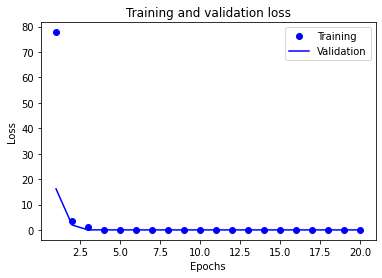

In [46]:
visualize(history_dict, 'loss')

In [47]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.0727


0.07269889861345291

## [Problem 6] Learning MNIST with Keras

In [48]:
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data()
X.shape, X_test.shape, X[0].dtype

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), dtype('uint8'))

In [49]:
X = X.reshape(-1, 28, 28, 1).astype(np.float)
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float)
X /= 255
X_test /= 255
X.shape, X_test.shape, X.min(), X.max(), y.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), 0.0, 1.0, (60000,), (10000,))

In [50]:
class LeNet(tf.keras.Model):
    def __init__(self):
        super(LeNet, self).__init__()
        self.inputs = tf.keras.layers.InputLayer(input_shape=(28, 28, 1))
        self.conv2d_1 = tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='SAME')
        self.pool_1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='VALID')
        self.conv2d_2 = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='SAME')
        self.pool_2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='VALID')
        self.dropout_1 = tf.keras.layers.Dropout(0.3)

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.dropout_2 = tf.keras.layers.Dropout(0.3)
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.dropout_3 = tf.keras.layers.Dropout(0.3)
        self.outputs = tf.keras.layers.Dense(10, activation='softmax')
    
    def call(self, inputs):
        x = self.inputs(inputs)
        x = self.conv2d_1(x)
        x = self.pool_1(x)
        x = self.conv2d_2(x)
        x = self.pool_2(x)
        x = self.dropout_1(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout_2(x)
        x = self.dense_2(x)
        x = self.dropout_3(x)
        return self.outputs(x)

In [51]:
model = LeNet()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X, y,
                    batch_size=100,
                    epochs=30,
                    validation_split=0.2,
                    verbose=2)
history_dict = history.history
history_dict.keys()

Epoch 1/30
480/480 - 34s - loss: 0.5070 - accuracy: 0.8385 - val_loss: 0.1215 - val_accuracy: 0.9643
Epoch 2/30
480/480 - 33s - loss: 0.1757 - accuracy: 0.9495 - val_loss: 0.0789 - val_accuracy: 0.9762
Epoch 3/30
480/480 - 34s - loss: 0.1350 - accuracy: 0.9611 - val_loss: 0.0655 - val_accuracy: 0.9799
Epoch 4/30
480/480 - 34s - loss: 0.1125 - accuracy: 0.9674 - val_loss: 0.0605 - val_accuracy: 0.9817
Epoch 5/30
480/480 - 34s - loss: 0.0971 - accuracy: 0.9713 - val_loss: 0.0547 - val_accuracy: 0.9839
Epoch 6/30
480/480 - 34s - loss: 0.0848 - accuracy: 0.9746 - val_loss: 0.0489 - val_accuracy: 0.9856
Epoch 7/30
480/480 - 34s - loss: 0.0791 - accuracy: 0.9764 - val_loss: 0.0488 - val_accuracy: 0.9853
Epoch 8/30
480/480 - 34s - loss: 0.0725 - accuracy: 0.9784 - val_loss: 0.0413 - val_accuracy: 0.9882
Epoch 9/30
480/480 - 34s - loss: 0.0650 - accuracy: 0.9802 - val_loss: 0.0392 - val_accuracy: 0.9891
Epoch 10/30
480/480 - 34s - loss: 0.0586 - accuracy: 0.9822 - val_loss: 0.0409 - val_accura

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

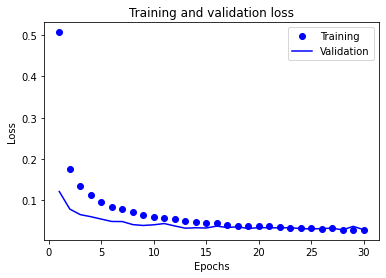

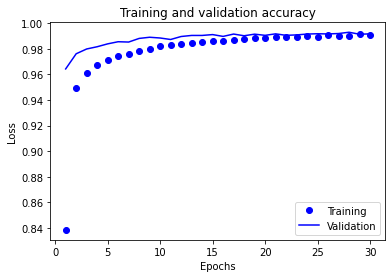

In [52]:
visualize(history_dict, 'loss')
visualize(history_dict, 'accuracy')

## [Problem 7] (Advance assignment) Rewriting to PyTorch

In [61]:
import torch
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cpu device


### Iris binary classification

In [120]:
df = pd.read_csv('Iris.csv')
data = df[df['Species'].isin(['Iris-versicolor', 'Iris-virginica'])]
X = data.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
y = data['Species']
y = np.where(y == 'Iris-versicolor', 0, 1)
X = np.array(X).astype(np.float32)
y = np.array(y)
y = y.astype(np.int64)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 4), (20, 4), (80, 1), (20, 1))

In [121]:
class IrisBinaryDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = self.X[idx, :]
        y = self.y[idx, 0]
        return X, y

train_data = DataLoader(IrisBinaryDataset(X_train, y_train), batch_size=10, shuffle=True)
test_data = DataLoader(IrisBinaryDataset(X_test, y_test), batch_size=10, shuffle=True)

for X, y in train_data:
    print(X.shape)
    print(y.shape, y.dtype)
    break

torch.Size([10, 4])
torch.Size([10]) torch.int64


In [122]:
class IrisBinaryClassifierTorch(torch.nn.Module):
    def __init__(self):
        super(IrisBinaryClassifierTorch, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 2),
            torch.nn.Sigmoid()
        )
    
    def forward(self, inputs):
        return self.seq(inputs)

model = IrisBinaryClassifierTorch().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, loss_fn, optimizer

(IrisBinaryClassifierTorch(
   (seq): Sequential(
     (0): Linear(in_features=4, out_features=50, bias=True)
     (1): ReLU()
     (2): Linear(in_features=50, out_features=100, bias=True)
     (3): ReLU()
     (4): Linear(in_features=100, out_features=2, bias=True)
     (5): Sigmoid()
   )
 ), CrossEntropyLoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [129]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.double).sum().item()
        
    test_loss /= num_batches
    correct /= size
    print(f"Test error:\nAccuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")

In [131]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}")
    train(train_data, model, loss_fn, optimizer)
    test(test_data, model, loss_fn)
    print("----------------------------")

Epoch 1
Test error:
Accuracy: 90.0%, Avg loss: 0.431728
----------------------------
Epoch 2
Test error:
Accuracy: 95.0%, Avg loss: 0.415702
----------------------------
Epoch 3
Test error:
Accuracy: 90.0%, Avg loss: 0.427239
----------------------------
Epoch 4
Test error:
Accuracy: 90.0%, Avg loss: 0.415804
----------------------------
Epoch 5
Test error:
Accuracy: 90.0%, Avg loss: 0.414361
----------------------------
Epoch 6
Test error:
Accuracy: 90.0%, Avg loss: 0.432226
----------------------------
Epoch 7
Test error:
Accuracy: 95.0%, Avg loss: 0.405921
----------------------------
Epoch 8
Test error:
Accuracy: 90.0%, Avg loss: 0.428582
----------------------------
Epoch 9
Test error:
Accuracy: 95.0%, Avg loss: 0.409111
----------------------------
Epoch 10
Test error:
Accuracy: 95.0%, Avg loss: 0.406082
----------------------------


### Iris multi-classification

In [146]:
from sklearn.preprocessing import LabelEncoder

X, y = df.loc[:, ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']], df['Species']
X = np.array(X)
y = np.array(y)
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [147]:
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = self.X[idx, :].astype(np.float32)
        y = self.y[idx].astype(np.int64)
        return X, y

train_data = DataLoader(IrisDataset(X_train, y_train), batch_size=10, shuffle=True)
test_data = DataLoader(IrisDataset(X_test, y_test), batch_size=10, shuffle=True)

for X, y in train_data:
    print(X.shape)
    print(y.shape, y.dtype)
    break

torch.Size([10, 4])
torch.Size([10]) torch.int64


In [148]:
class IrisClassifierTorch(torch.nn.Module):
    def __init__(self):
        super(IrisClassifierTorch, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 3)
        )
    
    def forward(self, inputs):
        return self.seq(inputs)

model = IrisClassifierTorch().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, loss_fn, optimizer

(IrisClassifierTorch(
   (seq): Sequential(
     (0): Linear(in_features=4, out_features=50, bias=True)
     (1): ReLU()
     (2): Linear(in_features=50, out_features=100, bias=True)
     (3): ReLU()
     (4): Linear(in_features=100, out_features=3, bias=True)
   )
 ), CrossEntropyLoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [149]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}")
    train(train_data, model, loss_fn, optimizer)
    test(test_data, model, loss_fn)
    print("----------------------------")

Epoch 1
Test error:
Accuracy: 20.0%, Avg loss: 1.091583
----------------------------
Epoch 2
Test error:
Accuracy: 56.7%, Avg loss: 0.940236
----------------------------
Epoch 3
Test error:
Accuracy: 56.7%, Avg loss: 0.810180
----------------------------
Epoch 4
Test error:
Accuracy: 56.7%, Avg loss: 0.739741
----------------------------
Epoch 5
Test error:
Accuracy: 63.3%, Avg loss: 0.606876
----------------------------
Epoch 6
Test error:
Accuracy: 70.0%, Avg loss: 0.522908
----------------------------
Epoch 7
Test error:
Accuracy: 70.0%, Avg loss: 0.463546
----------------------------
Epoch 8
Test error:
Accuracy: 70.0%, Avg loss: 0.448234
----------------------------
Epoch 9
Test error:
Accuracy: 86.7%, Avg loss: 0.375174
----------------------------
Epoch 10
Test error:
Accuracy: 86.7%, Avg loss: 0.351999
----------------------------


### House Prices prediction

In [179]:
df = pd.read_csv('train.csv')

X, y = df[["GrLivArea", "YearBuilt"]], df[["SalePrice"]]
X = np.array(np.log1p(X))
y = np.array(np.log1p(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1168, 2), (292, 2), (1168, 1), (292, 1))

In [180]:
class HousePricesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        X = self.X[idx, :].astype(np.float32)
        y = self.y[idx, :].astype(np.float32)
        return X, y

train_data = HousePricesDataset(X_train, y_train)
test_data = HousePricesDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=10, shuffle=True)

for X, y in train_dataloader:
    print(X.shape)
    print(y.shape, y.dtype)
    break

torch.Size([10, 2])
torch.Size([10, 1]) torch.float32


In [181]:
class TorchRegressor(torch.nn.Module):
    def __init__(self):
        super(TorchRegressor, self).__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(2, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1)
        )
    
    def forward(self, inputs):
        return self.seq(inputs)

model = TorchRegressor().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, loss_fn, optimizer

(TorchRegressor(
   (seq): Sequential(
     (0): Linear(in_features=2, out_features=100, bias=True)
     (1): ReLU()
     (2): Linear(in_features=100, out_features=100, bias=True)
     (3): ReLU()
     (4): Linear(in_features=100, out_features=1, bias=True)
   )
 ), MSELoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [182]:
def train_regression(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

def test_regression(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        
    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f}")

In [184]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}")
    train_regression(train_dataloader, model, loss_fn, optimizer)
    test_regression(test_dataloader, model, loss_fn)
    print("----------------------------")

Epoch 1
Train loss: 0.080264
Test loss: 0.079713
----------------------------
Epoch 2
Train loss: 0.081873
Test loss: 0.070435
----------------------------
Epoch 3
Train loss: 0.088541
Test loss: 0.068078
----------------------------
Epoch 4
Train loss: 0.085400
Test loss: 0.073815
----------------------------
Epoch 5
Train loss: 0.082184
Test loss: 0.071763
----------------------------
Epoch 6
Train loss: 0.085005
Test loss: 0.067843
----------------------------
Epoch 7
Train loss: 0.079480
Test loss: 0.068064
----------------------------
Epoch 8
Train loss: 0.078851
Test loss: 0.068019
----------------------------
Epoch 9
Train loss: 0.081780
Test loss: 0.070705
----------------------------
Epoch 10
Train loss: 0.084160
Test loss: 0.070137
----------------------------


### MNIST

In [185]:
import torchvision

train_data = torchvision.datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [186]:
batch_size = 100

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([100, 1, 28, 28])
Shape of y:  torch.Size([100]) torch.int64


In [191]:
import torch.nn.functional as F

class LeNetTorch(torch.nn.Module):
    def __init__(self):
        super(LeNetTorch, self).__init__()
        self.conv2d_1 = torch.nn.Conv2d(1, 6, 5, padding=(2, 2))
        self.conv2d_2 = torch.nn.Conv2d(6, 16, 5, padding=(2, 2))
        self.dense_1 = torch.nn.Linear(16 * 7 * 7, 120)
        self.dense_2 = torch.nn.Linear(120, 84)
        self.dense_3 = torch.nn.Linear(84, 10)
    
    def forward(self, inputs):
        x = F.max_pool2d(F.relu(self.conv2d_1(inputs)), 2)
        x = F.max_pool2d(F.relu(self.conv2d_2(x)), 2)
        x = torch.flatten(F.dropout2d(x, p=0.3), 1)
        x = F.dropout(F.relu(self.dense_1(x)), p=0.3)
        x = F.dropout(F.relu(self.dense_2(x)), p=0.3)
        return self.dense_3(x)

model = LeNetTorch().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, loss_fn, optimizer

(LeNetTorch(
   (conv2d_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (conv2d_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (dense_1): Linear(in_features=784, out_features=120, bias=True)
   (dense_2): Linear(in_features=120, out_features=84, bias=True)
   (dense_3): Linear(in_features=84, out_features=10, bias=True)
 ), CrossEntropyLoss(), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 0
 ))

In [192]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t + 1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print("----------------------------")

Epoch 1
Test error:
Accuracy: 94.5%, Avg loss: 0.175446
----------------------------
Epoch 2
Test error:
Accuracy: 96.4%, Avg loss: 0.121848
----------------------------
Epoch 3
Test error:
Accuracy: 97.2%, Avg loss: 0.098588
----------------------------
Epoch 4
Test error:
Accuracy: 97.3%, Avg loss: 0.088140
----------------------------
Epoch 5
Test error:
Accuracy: 97.8%, Avg loss: 0.078449
----------------------------
Epoch 6
Test error:
Accuracy: 97.7%, Avg loss: 0.082600
----------------------------
Epoch 7
Test error:
Accuracy: 98.1%, Avg loss: 0.067569
----------------------------
Epoch 8
Test error:
Accuracy: 97.8%, Avg loss: 0.070299
----------------------------
Epoch 9
Test error:
Accuracy: 98.2%, Avg loss: 0.062071
----------------------------
Epoch 10
Test error:
Accuracy: 98.2%, Avg loss: 0.061413
----------------------------
Epoch 11
Test error:
Accuracy: 98.2%, Avg loss: 0.058889
----------------------------
Epoch 12
Test error:
Accuracy: 98.4%, Avg loss: 0.054717
------

## [Problem 8] (Advance assignment) Comparison of frameworks



*   Keras provides kinds of coding style which is friendly for beginner, higher readability. Keras has a higher level API, while PyTorch provides low-level API which may better for fine-grained work.
*   Keras is a bit like a black box which can be harder to debug than PyTorch, since PyTorch is lengthy but clearly.
*   PyTorch seems fater than Keras, as lower level approach can reduce unnecessary work.
*   Both frameworks provides sufficient popular ML functions and easy to read documentations. Keras provides more compact API functions which can be powerful and reliable in many case.

